# Data Exploration

In [ ]:
#!pip install tslearn
#!pip install sktime==0.5.0
#!pip install pyts

**UTILITY FUNCTIONS**

In [1]:
#https://colab.research.google.com/drive/1ngpyXDYcDfbaVu_TVhalUuGsoDRqQJa8?usp=sharing#scrollTo=SJEmePmuyb0l
#https://towardsdatascience.com/time-series-clustering-deriving-trends-and-archetypes-from-sequential-data-bb87783312b4
#https://towardsdatascience.com/multiple-time-series-classification-by-using-continuous-wavelet-transformation-d29df97c0442
from tslearn.metrics import dtw
from tslearn.metrics import cdist_gak,cdist_dtw

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans, KernelKMeans,KShape
from sklearn.cluster import DBSCAN, AgglomerativeClustering, Birch, MeanShift, AffinityPropagation, OPTICS
from tslearn.preprocessing import TimeSeriesScalerMeanVariance,TimeSeriesScalerMinMax
import pywt
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.fftpack import rfft
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from scipy import signal
import seaborn as sns
from sklearn import metrics
from matplotlib import ticker
from matplotlib import lines

%matplotlib inline  

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint





2023-03-15 12:07:43.532093: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-15 12:07:43.532112: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:

def smooth(x, window_len=11, window='hanning'):
    """smooth the data using a window with requested size.

    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal

    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)

    see also:

    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter

    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len < 3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s = np.r_[x[window_len - 1:0:-1], x, x[-2:-window_len - 1:-1]]
    # print(len(s))
    if window == 'flat':  # moving average
        w = np.ones(window_len, 'd')
    else:
        w = eval('np.' + window + '(window_len)')

    y = np.convolve(w / w.sum(), s, mode='valid')
    return y[:len(x)]

import copy
def smooth_multiple(x, window_len=11, window='hanning'):
    xc=copy.deepcopy(x)
    dims=xc.shape
    for i in range(dims[0]):
        xc[i,:,0]=smooth(xc[i,:,0],window_len, window)
    return xc


In [3]:
def create_confusion_matrix(y_pred, y_test,label_names):    
    #calculate the confusion matrix
    confmat = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(confmat, cmap=plt.cm.Blues, alpha=0.5)

    n_labels = len(label_names)
    ax.set_xticks(np.arange(n_labels))
    ax.set_yticks(np.arange(n_labels))
    ax.set_xticklabels(label_names)
    ax.set_yticklabels(label_names)

    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # loop over data dimensions and create text annotations.
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=i, y=j, s=confmat[i, j], va='center', ha='center')
    
    # avoid that the first and last row cut in half
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    ax.set_title("Confusion Matrix")
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

In [4]:
def createFeatureVec2(df, nPoints=None, nRows=None, pad_num=10, building=True, synthetic=True):
    """ group PSs of each building to a feature vector, pad/shrink to 10 points"""
    array_fp = np.array(df['footprint_id'])
    ftp_ids, counts = np.unique(array_fp,return_counts=True)
    np_timeseries_all = [] 
    if building==True:
        for ftp_id in ftp_ids:
            #ps_ids = df.index[df.footprint_id == ftp_id]
            #df_index = df.iloc[ps_ids]
            df_index = df[df.footprint_id == ftp_id]
            np_timeseries = df_index.filter(regex="20*").values
            #np_timeseries = signal.detrend(np_timeseries) ## Remove linear trend

            if np_timeseries.shape[0] < pad_num:
                    to_pad = pad_num - np_timeseries.shape[0]
                    #np_timeseries = np.pad(np_timeseries,((0,to_pad),(0,0))) ## v1: pad 0
                    np_timeseries = np.pad(np_timeseries,((0,to_pad),(0,0)),mode='mean') ## v2: pad mean
            else:
                    #np_timeseries = np_timeseries[:pad_num,:] ## v1: first 10 values
                    kmeans = KMeans(n_clusters=pad_num).fit(np_timeseries)
                    np_timeseries = kmeans.cluster_centers_ ## v2: kmeans cluster 10 values

            #np_timeseries = np_timeseries.reshape(np_timeseries.shape[1], 1, np_timeseries.shape[0])
            np_timeseries=np.transpose(np_timeseries,(1, 0))
            np_timeseries=np.expand_dims(np_timeseries, 1)
            np_timeseries_all.append(np_timeseries.astype('float32'))

        return ftp_ids, np.concatenate(np_timeseries_all,axis=1) # (seq_len, batch_size, input_size)
    else:
        np_timeseries=df.filter(regex="20*").values
        np_timeseries=np.transpose(np_timeseries,(1, 0))
        np_timeseries=np.expand_dims(np_timeseries, -1)
        #np_timeseries_all.append(np_timeseries.astype('float32'))
        if synthetic:
            return df.index.values,np.array(df['footprint_id']), df.anomaly.values-1, np_timeseries
        else:
            return df.index.values,np.array(df['footprint_id']),np.zeros(len(df.index.values)), np_timeseries

In [5]:
def plot_clusters(X, y_pred, y_true, cluster_centers,label_names=None):
    sz = X.shape[1]
    plt.figure()
    for yi in range(3):
        plt.subplot(3, 1, 1 + yi)
        for xx in X[y_pred == yi]:
            plt.plot(xx.ravel(), "y-", alpha=.1)
        plt.plot(cluster_centers[yi].ravel(), "r-")
        plt.xlim(0, sz)
        plt.ylim(-4, 4)
        plt.title("Cluster: {}".format(label_names[yi]))

    plt.tight_layout()
    plt.show()
    
    create_confusion_matrix(y_pred, y_true,label_names)
    #ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    
def fit_clusters(model, n_cluster,X, y_true,centroids):
    if model == 'kshape':
        model = KShape(n_clusters=n_cluster, max_iter=100, n_init=3, init=centroids,random_state=42).fit(X)
    elif model == 'kmeans':
        model = TimeSeriesKMeans(n_clusters=n_cluster, metric="euclidean", max_iter=100, n_init=3,init=centroids,random_state=42).fit(X)
    elif model == 'dtw':
        model = TimeSeriesKMeans(n_clusters=n_cluster, metric="dtw", max_iter=100, n_init=3,init=centroids,random_state=42).fit(X)
    elif model == 'softdtw':
        model = TimeSeriesKMeans(n_clusters=n_cluster, metric="softdtw", max_iter=100, n_init=3,init=centroids,random_state=42).fit(X)
    elif model == 'kernelkmeans':
        model = KernelKMeans(n_clusters=n_cluster, kernel="gak", max_iter=100, n_init=3,random_state=42).fit(X)
    elif model == 'dbscan':
        model = DBSCAN(n_jobs=-1,metric="correlation", min_samples=5,eps=0.5).fit(np.mean(X,-1,keepdims=False)) #correlation
    elif model == 'agglomerative':
        model = AgglomerativeClustering(distance_threshold=None, n_clusters=n_cluster, linkage="complete").fit(np.mean(X,-1,keepdims=False))
    elif model == 'birch':
        model = Birch(n_clusters=n_cluster).fit(np.mean(X,-1,keepdims=False))
    elif model == 'meanshift':
        model = MeanShift().fit(np.mean(X,-1,keepdims=False))
    elif model == 'affinity':
        model = AffinityPropagation().fit(np.mean(X,-1,keepdims=False))
    elif model == 'optics':
        model = OPTICS().fit(np.mean(X,-1,keepdims=False))
    else:
        model = TimeSeriesKMeans(n_clusters=n_cluster, metric="euclidean", max_iter=10, n_init=2).fit(X)
        
        
    return model.labels_,model.cluster_centers_


In [6]:
def plot_3d(points, title="3D"):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()
    

def plot_2d(points, colors, centers,  label_colors, label_names,title=None):
    fig, ax = plt.subplots(figsize=(5, 5), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, colors, centers, label_colors,label_names)
    plt.show()


def add_2d_scatter(ax, points, colors, centers, label_colors,label_names, title=None):
    x, y = points.T
    c1, c2=centers.T
    ax.scatter(x, y, c=colors, s=50, alpha=0.8)
    for i,j,k,l in zip(c1,c2,label_colors,label_names):
        ax.scatter(i, j, c=k, s=50, alpha=0.8, label=l)
    ax.set_title(title)
    plt.legend()
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())


In [7]:
def split_indices_per_label(y):
    indicies_per_label = [[] for x in range(0,6)]
    # loop over the six labels
    for i in range(6): 
        indicies_per_label[i] = np.where(y == i)[0]
    return indicies_per_label

def plot_cwt_coeffs_per_label(X, label_indicies, label_names, signal, sample, scales, wavelet):
    
    fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12,5))
    
    for ax, indices, name in zip(axs.flat, label_indicies, label_names):
        # apply  PyWavelets continuous wavelet transfromation function
        tobe=X[indices[sample],:, signal]
        coeffs, freqs = pywt.cwt(tobe, scales, wavelet = wavelet)
        #print(coeffs)
        # create scalogram
        ax.imshow(coeffs.imag, cmap = 'coolwarm', aspect = 'auto')
        ax.set_title(name)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel('Scale')
        ax.set_xlabel('Time')
    plt.tight_layout()

In [8]:
def create_cwt_images(X, n_scales, rescale_size, wavelet_name = "morl"):
    n_samples = X.shape[0] 
    n_signals = X.shape[2] 
    
    # range of scales from 1 to n_scales
    scales = np.arange(1, n_scales + 1) 
    
    # pre allocate array
    X_cwt = np.ndarray(shape=(n_samples, rescale_size, rescale_size, n_signals), dtype = 'float32')
    
    for sample in range(n_samples):
        if sample % 1000 == 0:
            print(sample)
        for signal in range(n_signals):
            serie = X[sample, :, signal]
            # continuous wavelet transform 
            coeffs, freqs = pywt.cwt(serie, scales, wavelet_name)
            
            # resize the 2D cwt coeffs
            rescale_coeffs = resize(coeffs.real, (rescale_size, rescale_size), mode = 'constant')
            X_cwt[sample,:,:,signal] = rescale_coeffs
            
    return X_cwt

In [9]:
def plot_psp_distribution(df_data_train,df_data_test):
    def _extract_histogram(df_data):
        hist_list=[]
        for name, group in df_data.groupby(['footprint_id']):
            hist_list.append(len(group))
        np_hist=np.asarray(hist_list)
        return np_hist
    
    train_data_hist=_extract_histogram(df_data_train)
    test_data_hist=_extract_histogram(df_data_test)
    
    #fig1, ax1 = plt.subplots(1,1,figsize=(8, 3.5), sharex=True)
    fig, axs = plt.subplots(nrows=2,ncols=1,sharey=True,sharex=True,figsize=(7, 6))
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.ylabel('Occurence of PS instances [%]',size = 14,alpha=0.8)
    plt.xlabel('Number of PS instances per building',size = 14,alpha=0.8)
    #fig1.tight_layout()
    axs[0].hist(train_data_hist, bins=40, color='cadetblue', label="PS instance histogram",density=True, edgecolor='black',rwidth=0.8,linewidth=1,align='mid')
    print("MEDIAN PSP per building in Training {}".format(np.median(train_data_hist)))
    print("MEAN PSP per building in Training {}".format(np.mean(train_data_hist)))
    print("MEDIAN PSP per building in Test {}".format(np.median(test_data_hist)))
    print("Mean PSP per building in Test {}".format(np.mean(test_data_hist)))
    #ax1.vlines(x=np.median(train_data_hist), ymin=-1, ymax=60, colors='red',linestyle="solid", lw=1.5)

    axs[0].set_title("Distribution of PS Instances per Building in Training Set", size = 15,alpha=0.8)
    #plt.xlim(0, 450)
    #plt.ylim(0, 0.25)
    axs[0].grid(True)
    #axs[0].set_ylabel('Occurence of PS instances [%]',size = 14,alpha=0.8)
    axs[0].legend(prop={'size': 12})
    axs[0].set_yscale('log')
    #plt.savefig('hist_psp_train.png', dpi=300,bbox_inches='tight')
    #plt.show()

    #fig1, ax1 = plt.subplots(1,1,figsize=(8, 3.5), sharex=True)
    #fig1.tight_layout()
    axs[1].hist(test_data_hist, bins=50, color='brown', label="PS instance histogram",density=True, edgecolor='black',rwidth=0.8,linewidth=1,align='mid')
    axs[1].set_title("Distribution of PS Instances per Building in Test Set",size = 16,alpha=0.8)
    #plt.xlim(0, 450)
    #plt.ylim(0, 0.25)
    axs[1].grid(True)
    #axs[1].set_xlabel('Number of PSP per building',size = 14,alpha=0.8)
    axs[1].legend(prop={'size': 12})
    axs[1].set_yscale('log')
    
    
    plt.savefig('hist_psp_instances.png', dpi=300,bbox_inches='tight')
    plt.show()

In [74]:
def convert_to_df(pred_1,pred_2,pred_3,label_names,avg=True):
    a1=np.array([np.full(len(pred_1),label_names[0]),np.full(len(pred_1),0),1-pred_1])
    a1_mean=np.array([label_names[0],1,1-np.mean(pred_1)]).reshape(3,1)

    a2=np.array([np.full(len(pred_2),label_names[1]),np.full(len(pred_2),0),1-pred_2])
    a2_mean=np.array([label_names[1],1,1-np.mean(pred_2)]).reshape(3,1)

    a3=np.array([np.full(len(pred_3),label_names[2]),np.full(len(pred_3),0),1-pred_3])
    a3_mean=np.array([label_names[2],1,1-np.mean(pred_3)]).reshape(3,1)

    if avg:
        df = pd.DataFrame(np.concatenate([a1,a2,a3,a1_mean,a2_mean,a3_mean],1).T,columns=["type","status","result"])
    else:
        df = pd.DataFrame(np.concatenate([a1,a2,a3],1).T,columns=["type","status","result"])
        
    df=df.astype({"status":float,"result":float})
    return df

def anomaly_statistics(pred):
    Q1 = np.percentile(pred,25)
    med = np.median(pred)
    Q3 = np.percentile(pred,75)
    IQR = Q3 - Q1
    LowerWhisker = np.max([pred.min() , Q1-1.5*IQR])
    UpperWhisker = np.min([pred.max() , Q3 + 1.5 * IQR]) 
    return (LowerWhisker,UpperWhisker)

In [11]:
def build_cnn_model(activation, input_shape):
    model = Sequential()
    
    # 2 Convolution layer with Max polling
    model.add(Conv2D(32, 5, activation = activation, padding = 'same', input_shape = input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, 5, activation = activation, padding = 'same', kernel_initializer = "he_normal"))
    model.add(MaxPooling2D())  
    model.add(Flatten())
    
    # 3 Full connected layer
    model.add(Dense(128, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(54, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(3, activation = 'softmax')) # 6 classes
    
    # summarize the model
    print(model.summary())
    return model

def compile_and_fit_model(model, X_train, y_train, X_test, y_test, batch_size, n_epochs):

    # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])
    
    # define callbacks
    callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_sparse_categorical_accuracy', save_best_only=True)]
    
    # fit the model
    history = model.fit(x=X_train,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=n_epochs,
                        verbose=1,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))
    
    return model, history


**DATA READING**

In [12]:
ANOMALY_NAMES={0:"trend",1:"noise", 2:"step"}

df_results_synthetic = pd.read_csv('results/parameter_search/ls_1_lt_dtw_lr_0.001_pr_0_sw_5_in_True_id_False_ip_True_ed_32_gh_8_gl_2_tn_2_prediction_results_organic_final.csv')
df_data_synthetic_test = pd.read_csv('data/valdataset_3_3_3.csv')
df_data_original_test = pd.read_csv('data/database_test.csv')
df_data_original_train = pd.read_csv('data/database_train.csv')

df_data_synthetic_test = df_data_synthetic_test.fillna(0)
df_data_original_test = df_data_original_test.fillna(0)
df_data_original_train = df_data_original_train.fillna(0)

#print(len(np.unique(df_data_synthetic_test.index)))
#print(len(np.unique(df_data_original_test.index)))
#print(len(np.unique(df_data_original_train.index)))
#df_anomalies=df_data_synthetic[(df_data_synthetic.anomaly!=0)]


MEDIAN PSP per building in Training 4.0
MEAN PSP per building in Training 6.519800161633973
MEDIAN PSP per building in Test 4.0
Mean PSP per building in Test 6.582995413148973


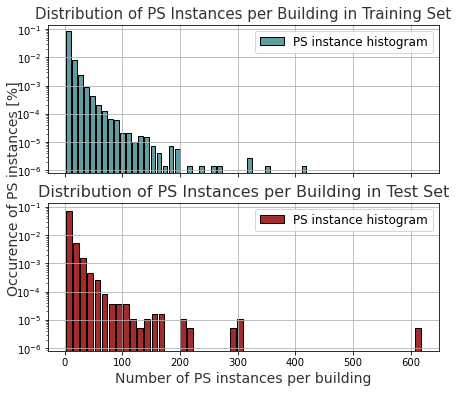

In [13]:
plot_psp_distribution(df_data_original_train,df_data_original_test)

In [14]:
"""
#ORDER BY HIGHEST PERTURBATION OF BUILDING IDs (note that df_results is already ordered)
df_data_synthetic_test.footprint_id = df_data_synthetic_test.footprint_id.astype("category")
df_data_synthetic_test.footprint_id = df_data_synthetic_test.footprint_id.cat.set_categories(df_results_synthetic.footprint_id.values)
df_data_synthetic_ordered=df_data_synthetic_test.sort_values(["footprint_id"]
)
"""

'\n#ORDER BY HIGHEST PERTURBATION OF BUILDING IDs (note that df_results is already ordered)\ndf_data_synthetic_test.footprint_id = df_data_synthetic_test.footprint_id.astype("category")\ndf_data_synthetic_test.footprint_id = df_data_synthetic_test.footprint_id.cat.set_categories(df_results_synthetic.footprint_id.values)\ndf_data_synthetic_ordered=df_data_synthetic_test.sort_values(["footprint_id"]\n)\n'

In [15]:
"""
#GET HIGHEST anomalies from each category
PERCENT=1

best_percent=df_results_synthetic[0:PERCENT*len(df_results_synthetic)//100]
anomaly_1_ids=df_data_synthetic_ordered[(df_data_synthetic_ordered.anomaly==1)].footprint_id.values
anomaly_2_ids=df_data_synthetic_ordered[(df_data_synthetic_ordered.anomaly==2)].footprint_id.values
anomaly_3_ids=df_data_synthetic_ordered[(df_data_synthetic_ordered.anomaly==3)].footprint_id.values

print(len(np.unique(anomaly_1_ids)))
print(len(np.unique(anomaly_2_ids)))
print(len(np.unique(anomaly_3_ids)))
print(np.unique(anomaly_1_ids))
print(np.unique(anomaly_2_ids))
print(np.unique(anomaly_3_ids))
"""

'\n#GET HIGHEST anomalies from each category\nPERCENT=1\n\nbest_percent=df_results_synthetic[0:PERCENT*len(df_results_synthetic)//100]\nanomaly_1_ids=df_data_synthetic_ordered[(df_data_synthetic_ordered.anomaly==1)].footprint_id.values\nanomaly_2_ids=df_data_synthetic_ordered[(df_data_synthetic_ordered.anomaly==2)].footprint_id.values\nanomaly_3_ids=df_data_synthetic_ordered[(df_data_synthetic_ordered.anomaly==3)].footprint_id.values\n\nprint(len(np.unique(anomaly_1_ids)))\nprint(len(np.unique(anomaly_2_ids)))\nprint(len(np.unique(anomaly_3_ids)))\nprint(np.unique(anomaly_1_ids))\nprint(np.unique(anomaly_2_ids))\nprint(np.unique(anomaly_3_ids))\n'

**SYNTHETIC ANOMALY FILTERING**

In [16]:
anomaly_1_ids=df_data_synthetic_test[(df_data_synthetic_test.anomaly==1)].footprint_id.values
anomaly_2_ids=df_data_synthetic_test[(df_data_synthetic_test.anomaly==2)].footprint_id.values
anomaly_3_ids=df_data_synthetic_test[(df_data_synthetic_test.anomaly==3)].footprint_id.values

counter=0
idx_list=[]
count_list=[]
for idx, anom_ids in enumerate([np.unique(anomaly_1_ids), np.unique(anomaly_2_ids), np.unique(anomaly_3_ids)]):
    counter=0
    #print(anom_ids)
    for i in anom_ids:
        sub=df_data_synthetic_test[(df_data_synthetic_test.footprint_id==i) & (df_data_synthetic_test.anomaly!=0)]
        #print(sub.anomaly.values)
        if len(sub)>5: # SELECT ONLY RELIABLE BUILDINGS WITH MORE THAN 4 PSP
            idx_list.append(np.array(sub.index.values))
            counter=counter+1
            if counter==250: break
    print("NUMBER OF BUILDING SELECTED FOR ANOMALY {}: {}".format(ANOMALY_NAMES[idx],counter))
    count_list.append(counter)
    #break
            
anomaly_ids=np.concatenate(idx_list)
df_anomalies = df_data_synthetic_test.iloc[anomaly_ids]
y_true_building= np.concatenate((np.full((count_list[0]), 0),np.full((count_list[1]), 1),np.full((count_list[2]), 2)))
#print(len(np.unique(anomaly_1_ids)))
#print(len((anomaly_1_ids)))
#print(len(df_anomalies))
#y_true_building


NUMBER OF BUILDING SELECTED FOR ANOMALY trend: 184
NUMBER OF BUILDING SELECTED FOR ANOMALY noise: 211
NUMBER OF BUILDING SELECTED FOR ANOMALY step: 178


**INPUT DATA SMOOTHING**

In [17]:

uiq_train,fp_train,_, ts_train = createFeatureVec2(df_data_original_train, pad_num=5, building=False,synthetic=False)
uiq_test,fp_test,_, ts_test = createFeatureVec2(df_data_original_test, pad_num=5, building=False,synthetic=False)
uiq_anom,fp_anom, y_true, anomaly_synthetic = createFeatureVec2(df_anomalies, pad_num=5, building=False)


x_test_synthetic=np.transpose(anomaly_synthetic,(1, 0, 2))
x_test_synthetic.shape  #n_samples, n_steps, n_signals
#y_true=y_true_building

ts_train=np.transpose(ts_train,(1, 0, 2))
ts_test=np.transpose(ts_test,(1, 0, 2))

#INDEX=0
#ts_train=smooth_multiple(ts_train[:,INDEX:,:],window_len=5)
#ts_test=smooth_multiple(ts_test[:,INDEX:,:],window_len=5)
#anomaly_synthetic=smooth_multiple(anomaly_synthetic[:,INDEX:,:],window_len=9)
#x_test_synthetic=smooth_multiple(x_test_synthetic[:,INDEX:,:],window_len=5)


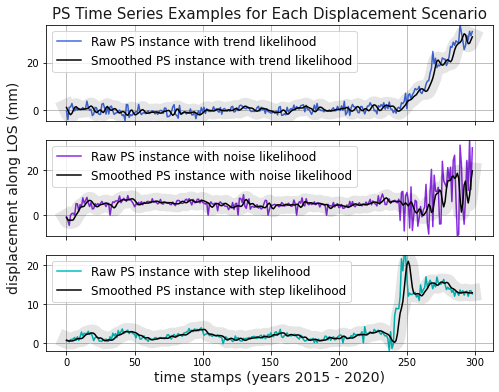

In [18]:
color_elements={0:'royalblue',1:'blueviolet',2:'c'}     
uidx_1=df_results_synthetic[(df_results_synthetic.footprint_id.isin(anomaly_1_ids)) & (df_results_synthetic.unique_id.isin(uiq_anom))].sort_values("loss").unique_id.values[-5]
uidx_2=df_results_synthetic[(df_results_synthetic.footprint_id.isin(anomaly_2_ids))& (df_results_synthetic.unique_id.isin(uiq_anom))].sort_values("loss").unique_id.values[-5]
uidx_3=df_results_synthetic[(df_results_synthetic.footprint_id.isin(anomaly_3_ids))& (df_results_synthetic.unique_id.isin(uiq_anom))].sort_values("loss").unique_id.values[-8]

fig, axs = plt.subplots(nrows=3,ncols=1,sharey=False,sharex=True,figsize=(8, 6))
fig.add_subplot(111, frameon=False)
for idx, uix in enumerate([uidx_1,uidx_2,uidx_3]):
    uix=np.where(uiq_anom==uix)[0]
    smothed_13=smooth_multiple(x_test_synthetic,7)
    axs[idx].plot(x_test_synthetic[uix,:,0].ravel(), color=color_elements[idx])
    axs[idx].plot(smothed_13[uix,:,0].ravel(), color="black")
    axs[idx].plot(smothed_13[uix,:,0].ravel(), color="black",alpha=0.1,linewidth=17.0)

    axs[idx].set_ylim(np.min(x_test_synthetic[uix,:,0]), np.max(x_test_synthetic[uix,:,0]))
    axs[idx].legend(["Raw PS instance with {} likelihood".format(ANOMALY_NAMES[idx]), 
                     "Smoothed PS instance with {} likelihood".format(ANOMALY_NAMES[idx])],prop={'size': 12})#loc='any left'

    axs[idx].grid()
plt.title("PS Time Series Examples for Each Displacement Scenario",size = 15,alpha=0.9)
#ax.legend(legend_element, ["PS instance for {} anomaly".format(label_names[ANOMALY])],prop={'size': 12})
plt.xlabel('time stamps (years 2015 - 2020)',size = 14,alpha=0.9,labelpad=20)
#plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.ylabel('displacement along LOS (mm)',size = 14,alpha=0.9,labelpad=25)
fig.savefig("displacement_scenarios.png",dpi=300,bbox_inches='tight')

**COMPARISON OF SYNTHETIC VS ORGANIC**

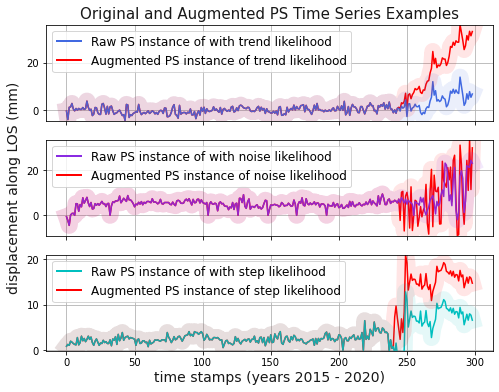

In [19]:
uidx_1=df_results_synthetic[(df_results_synthetic.footprint_id.isin(anomaly_1_ids)) & (df_results_synthetic.unique_id.isin(uiq_anom))].sort_values("loss").unique_id.values[-5]
uidx_2=df_results_synthetic[(df_results_synthetic.footprint_id.isin(anomaly_2_ids))& (df_results_synthetic.unique_id.isin(uiq_anom))].sort_values("loss").unique_id.values[-5]
uidx_3=df_results_synthetic[(df_results_synthetic.footprint_id.isin(anomaly_3_ids))& (df_results_synthetic.unique_id.isin(uiq_anom))].sort_values("loss").unique_id.values[-2]

fig, axs = plt.subplots(nrows=3,ncols=1,sharey=False,sharex=True,figsize=(8, 6))
fig.add_subplot(111, frameon=False)

legend_elements = [lines.Line2D([0], [0], color='royalblue',lw=2, linestyle="solid"),
                   lines.Line2D([0], [0], color='blueviolet', lw=2, linestyle="solid"),
                   lines.Line2D([0], [0], color='c', lw=2,linestyle="solid"),
                   lines.Line2D([0], [0], color='red', lw=2,linestyle="solid")]
for idx, uix in enumerate([uidx_1,uidx_2,uidx_3]):
    uiy=np.where(uiq_anom==uix)[0]
    smothed_13=smooth_multiple(x_test_synthetic,13)
    axs[idx].plot(x_test_synthetic[uiy,:,0].ravel(),color="red")
    axs[idx].plot(ts_test[uix,:,0].ravel(), color=color_elements[idx])
    axs[idx].plot(ts_test[uix,:,0].ravel(), color=color_elements[idx],alpha=0.1,linewidth=17.0)
    axs[idx].plot(x_test_synthetic[uiy,:,0].ravel(),color="red",alpha=0.1,linewidth=17.0)
    axs[idx].set_ylim(np.min(x_test_synthetic[uiy,:,0]), np.max(x_test_synthetic[uiy,:,0]))
    axs[idx].legend([legend_elements[idx],legend_elements[-1]],
                    ["Raw PS instance of with {} likelihood".format(ANOMALY_NAMES[idx]), 
                     "Augmented PS instance of {} likelihood".format(ANOMALY_NAMES[idx])],prop={'size': 12},loc='upper left')#loc='upper left'

    axs[idx].grid()
plt.title("Original and Augmented PS Time Series Examples",size = 15,alpha=0.9)
#ax.legend(legend_element, ["PS instance for {} anomaly".format(label_names[ANOMALY])],prop={'size': 12})
plt.xlabel('time stamps (years 2015 - 2020)',size = 14,alpha=0.9,labelpad=20)
#plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.ylabel('displacement along LOS (mm)',size = 14,alpha=0.9,labelpad=25)
fig.savefig("synthetic_comparisons.png",dpi=300,bbox_inches='tight')

**FIND SYNTHETIC CLUSTER CENTERS**

In [122]:
scaler=TimeSeriesScalerMeanVariance()
scaler.fit(ts_train)
x_test_synthetic_norm = scaler.transform(x_test_synthetic)
x_test_organic_norm = scaler.transform(ts_test)
x_train_organic_norm = scaler.transform(ts_train)

#x_train_norm=np.mean(x_train_norm,-1,keepdims=True)
#X_train_norm_fft=rfft(x_train_norm)
#x_train=np.mean(x_train_raw,-1,keepdims=True)
#x_train_fft=rfft(x_train_raw)



centroids_norm=np.concatenate([np.median(x_test_synthetic_norm[y_true==0],0,keepdims=True),
                          np.median(x_test_synthetic_norm[y_true==1],0,keepdims=True),
                          np.median(x_test_synthetic_norm[y_true==2],0,keepdims=True)])

#centroids_norm_fft=np.concatenate([np.mean(X_train_norm_fft[y_true==0],0,keepdims=True),
#                          np.mean(X_train_norm_fft[y_true==1],0,keepdims=True),
#                          np.mean(X_train_norm_fft[y_true==2],0,keepdims=True)])

#centroids=np.concatenate([np.mean(x_test_synthetic[y_true==0],0,keepdims=True),
#                          np.mean(x_test_synthetic[y_true==1],0,keepdims=True),
#                          np.mean(x_test_synthetic[y_true==2],0,keepdims=True)])

#centroids_fft=np.concatenate([np.mean(x_train_fft[y_true==0],0,keepdims=True),
#                          np.mean(x_train_fft[y_true==1],0,keepdims=True),
#                          np.mean(x_train_fft[y_true==2],0,keepdims=True)])

              precision    recall  f1-score   support

         0.0       0.44      0.51      0.47      2247
         1.0       0.80      0.28      0.41      2003
         2.0       0.33      0.51      0.40      1697

    accuracy                           0.43      5947
   macro avg       0.52      0.43      0.43      5947
weighted avg       0.53      0.43      0.43      5947



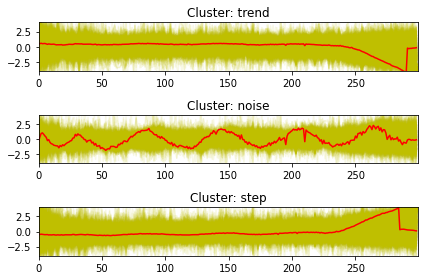

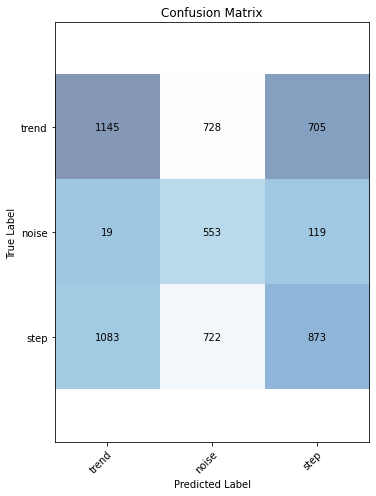

In [123]:
label_names=["trend","noise", "step" ]
#y_pred,cc=fit_clusters('kshape', 3,X_train_norm_fft,y_true,centroids_norm_fft)
#print(classification_report(y_true, y_pred))
#plot_clusters(x_train_norm, y_pred,y_true,cc)


y_pred,cc=fit_clusters('kshape', 3,x_test_synthetic_norm,y_true,centroids_norm)
print(classification_report(y_true, y_pred))
plot_clusters(x_test_synthetic_norm, y_pred,y_true,cc,label_names)

#y_pred,cc=fit_clusters('kshape', 3,x_train_fft,y_true,centroids_fft)
#print(classification_report(y_true, y_pred))
#plot_clusters(x_train_norm, y_pred,y_true,cc)

#y_pred,cc=fit_clusters('kmeans', 3,x_test_synthetic,y_true,centroids)
#print(classification_report(y_true, y_pred))
#plot_clusters(x_train_norm, y_pred,y_true,cc)

#y_pred=fit_clusters('kshape', 3,x_train_norm_fft,anomaly_labels,centroids_norm_fft)
#y_pred=fit_clusters('kshape', 3,x_train_norm,anomaly_labels,centroids_norm)
#y_pred=fit_clusters('kshape', 3,x_train,anomaly_labels,centroids)
#y_pred=fit_clusters('kmeans', 3,x_train_norm_fft,anomaly_labels,centroids_norm_fft)
#y_pred=fit_clusters('kmeans', 3,x_train_norm,anomaly_labels,centroids_norm)
#y_pred=fit_clusters('kmeans', 3,x_train,anomaly_labels,centroids)
#y_pred=fit_clusters('dtw', 3,x_train_norm_fft,anomaly_labels,centroids_norm_fft)
#y_pred=fit_clusters('dtw', 3,x_train_norm,anomaly_labels,centroids_norm)
#y_pred=fit_clusters('dtw', 3,x_train,anomaly_labels,centroids)


In [124]:
cluster_centers2=cc

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1145
         1.0       1.00      0.95      0.97       553
         2.0       0.97      0.99      0.98       873

    accuracy                           0.98      2571
   macro avg       0.98      0.98      0.98      2571
weighted avg       0.98      0.98      0.98      2571



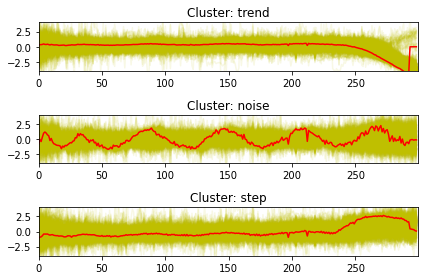

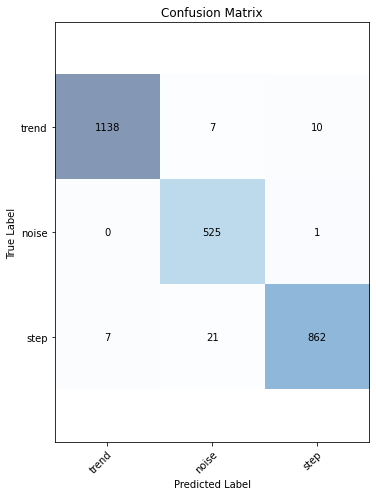

In [125]:
flag=y_pred==y_true
y_pred,cc=fit_clusters('kshape', 3,x_test_synthetic_norm[flag],y_true[flag],centroids_norm)
print(classification_report(y_true[flag], y_pred))
plot_clusters(x_test_synthetic_norm[flag], y_pred,y_true[flag],cc,label_names)

In [126]:
cluster_centers_3=cc

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1138
         1.0       1.00      1.00      1.00       525
         2.0       1.00      1.00      1.00       862

    accuracy                           1.00      2525
   macro avg       1.00      1.00      1.00      2525
weighted avg       1.00      1.00      1.00      2525



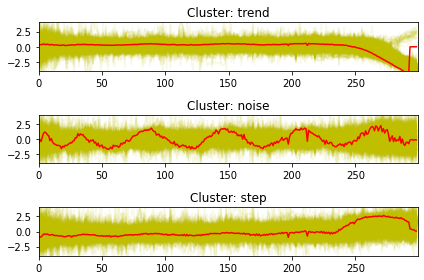

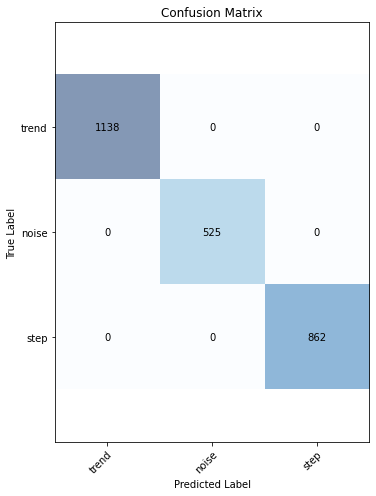

In [127]:
flag2=y_pred==y_true[flag]
y_pred2,cluster_centers_4=fit_clusters('kshape', 3,x_test_synthetic_norm[flag][flag2],y_true[flag][flag2],centroids_norm)
print(classification_report(y_true[flag][flag2], y_pred2))
plot_clusters(x_test_synthetic_norm[flag][flag2], y_pred2,y_true[flag][flag2],cluster_centers_4,label_names)

In [128]:
cluster_centers=cluster_centers_4

**DISTANCE TO CLUSTERS**

In [147]:
_, x_test_organic_norm_sub = train_test_split(x_test_organic_norm, test_size=0.5, random_state=42)
_, x_train_organic_norm_sub = train_test_split(x_train_organic_norm, test_size=0.05, random_state=42)
_, x_test_synthetic_norm_sub = train_test_split(x_test_synthetic_norm, test_size=0.1, random_state=42)


In [148]:
distance_ts=cdist_gak(x_train_organic_norm_sub, cluster_centers, sigma=23, n_jobs=-1, verbose=0) #23
#distance_ts=cdist_dtw(x_test_organic_norm, cluster_centers,  n_jobs=-1, verbose=1)


In [149]:
label_names=["trend","noise", "step" ]

pred_1=distance_ts[:,0]
pred_2=distance_ts[:,1]
pred_3=distance_ts[:,2]

p95, p5 = np.percentile(pred_1, [99.9, 5])
as1=anomaly_statistics(pred_1)
pred_1_out = pred_1[pred_1 > as1[-1]]

p95, p5 = np.percentile(pred_2, [99.9, 5])
as2=anomaly_statistics(pred_2)
pred_2_out = pred_2[pred_2 > as2[-1]]

p95, p5 = np.percentile(pred_3, [99.9, 5])
as3=anomaly_statistics(pred_3)
pred_3_out = pred_3[pred_3 > as3[-1]]

print(len(pred_1_out))
print(len(pred_2_out))
print(len(pred_3_out))

df=convert_to_df(pred_1,pred_2,pred_3,label_names)

df_out=convert_to_df(pred_1_out,pred_2_out,pred_3_out,label_names,False)

283
278
26


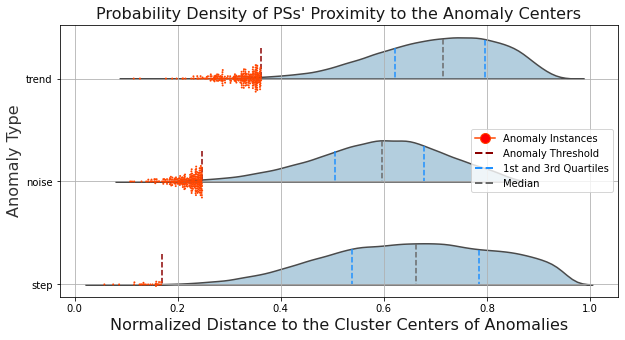

In [150]:
from  matplotlib.lines import Line2D

lins=[1-np.array(as1), 1-np.array(as2), 1-np.array(as3)]
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
sns.swarmplot(ax=ax, y="type", x="result",data=df_out, dodge=False, orient="h", size=2,color="orangered")
#sns.boxplot(ax=ax, y="type", x="result", hue='status',data=df, dodge=False, orient="h", color='red')

sns.violinplot(ax=ax,y=df["type"], x=df["result"],palette="Blues", hue=df['status'], dodge=False, split=True,scale="count", inner="quartile")
legend_elements = [Line2D([0], [0], marker='o', color='orangered', label='Scatter',markerfacecolor='red', markersize=10),
                   Line2D([0], [0], color='darkred', lw=2, label='Line',linestyle="dashed"),
                   Line2D([0], [0], color='dodgerblue', lw=2, label='Line',linestyle="dashed"),
                   Line2D([0], [0], color='dimgray', lw=2, label='Line',linestyle="dashed"),
                   
                
                  ]
ax.legend(legend_elements, [ 'Anomaly Instances','Anomaly Threshold','1st and 3rd Quartiles', 'Median',])
#ax.legend().set_visible(True)
ax.set_title("Probability Density of PSs' Proximity to the Anomaly Centers",size = 16,alpha=0.9)
ax.set_xlabel("Normalized Distance to the Cluster Centers of Anomalies",size = 16,alpha=0.9)
ax.set_ylabel("Anomaly Type",size = 16,alpha=0.8)
plt.grid()

for l in ax.lines:
    l.set_linestyle('--')
    #l.set_xdata(ll)
    l.set_linewidth(1.5)
    l.set_color('dodgerblue')
    #l.set_alpha(0.8)
for l in ax.lines[1::2]:
    l.set_linestyle('--')
    l.set_linewidth(1.5)
    l.set_color('dimgray')
    #l.set_alpha(0.8)

counter=0
for ll in lins:
    
    plt.vlines(x=ll[-1], ymin=-0.3+counter, ymax=0.0+counter, colors='darkred',linestyles ="dashed", lw=1.5)
    
    counter=counter+1
plt.autoscale()

plt.savefig("dataset_stats_2.png",bbox_inches = 'tight')#pad_inches = 0.1


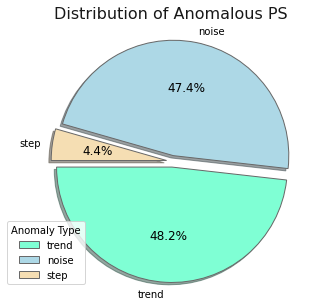

In [151]:
s1=np.sum((pred_1 > as1[-1]) & (pred_3 < as3[-1]) & (pred_2 < as2[-1]))
s2=np.sum((pred_2 > as2[-1]) & (pred_3 < as3[-1]) & (pred_1 < as1[-1]))
s3=np.sum((pred_3 > as3[-1]) & (pred_2 < as2[-1]) & (pred_1 < as1[-1]))
data=[s1,s2,s3]
 
# Creating dataset
# Creating explode data
explode = (0.05, 0.05, 0.05)
 
# Creating color parameters
colors = ("aquamarine", "lightblue","wheat", "indigo", "beige")
 
# Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "dimgrey" }
 
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%".format(pct)
 
# Creating plot
fig, ax = plt.subplots(figsize =(5, 5))

wedges, texts, autotexts = ax.pie(data,
                                  autopct = lambda pct: func(pct, data),
                                  explode = explode,
                                  labels = label_names,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 180,
                                  wedgeprops = wp,
                                  textprops = dict(color ="black"))
 
# Adding legend
ax.legend(wedges, label_names,
          title ="Anomaly Type",
          loc ="center left",
          bbox_to_anchor =(-0.14, -0.34, 0.5, 1))
 
plt.setp(autotexts, size = 12)# weight ="bold")
ax.set_title("Distribution of Anomalous PS",size = 16,alpha=0.9)
plt.autoscale()

# show plot
plt.savefig("dataset_stats_1.png")


**ANOMALY BUILDING LOCATION AND TYPE FINDING**

In [152]:
label_names=ANOMALY_NAMES
#df_data_original_test = df_data_original_test
#directory="/p/project/hai_eo_tree/kuzu/represent/represent_dlr/UC3/results/lstm/"
#org_dtw_p=directory+"1/ls_1_lt_dtw_lr_0.0005_pr_0_sw_5_in_True_id_False_ip_True_ed_32_tn_4_prediction_results_organic_final.csv"
#preds=pd.read_csv(org_dtw_p)
subset=df_results_synthetic[df_results_synthetic.loss>np.percentile(df_results_synthetic.loss.values,98)]
anomaly_likelihoods=[]
anomaly_fp=[]
lat=[]
long=[]
lat_building=[]
long_building=[]
anomaly_names=[]
trend_probs=[]
noise_probs=[]
step_probs=[]
anomaly_point_num=[]
total_point_num=[]
confidence=[]
unique_ids=[]
footprint_ids=[]
anomaly_ids=[]
anomaly_prediction=[]
for n, g in subset.groupby("footprint_id"):
    if len(g)>3:
        IDX=g.footprint_id.values[0]
        anomaly_fp.append(IDX)
        footprint_ids.append(g.footprint_id.values)
        
        anomaly_id=g.index.values
        total_point_num.append(sum(df_results_synthetic.footprint_id==IDX))
        anomaly_point_num.append(len(anomaly_id))
        unique_ids.append(anomaly_id)
        
        confidence.append(len(anomaly_id)/sum(df_results_synthetic.footprint_id==IDX))
        
        ano=np.argmax(cdist_gak(x_test_organic_norm[anomaly_id], cluster_centers, sigma=23, n_jobs=-1, verbose=0),1)
        anomaly_prediction.append(ano)
        
        unique, counts = np.unique(ano, return_counts=True)
        res={"trend": '{:.2f}'.format(sum(ano==0)/len(ano)),
             "noise": '{:.2f}'.format(sum(ano==1)/len(ano)),
             "step": '{:.2f}'.format(sum(ano==2)/len(ano))
            }
        trend_probs.append('{:.2f}'.format(sum(ano==0)/len(ano)))
        noise_probs.append('{:.2f}'.format(sum(ano==1)/len(ano)))
        step_probs.append('{:.2f}'.format(sum(ano==2)/len(ano)))
        sortedDict = sorted(res.items(),key=lambda x:x[1])[-1][0]
        anomaly_likelihoods.append(counts/sum(counts))
        anomaly_names.append(sortedDict)
        lat_building.append(df_data_original_test[df_data_original_test.footprint_id==IDX].latitude.values[0])
        long_building.append(df_data_original_test[df_data_original_test.footprint_id==IDX].longitude.values[0])
        lat.append(df_data_original_test[df_data_original_test.index.isin(anomaly_id)].latitude.values)
        long.append(df_data_original_test[df_data_original_test.index.isin(anomaly_id)].longitude.values)

df_ano_build=pd.DataFrame({'footprint_id':anomaly_fp,
                 'anomaly_type':anomaly_names,
                 'trend_anomaly_likelihood':trend_probs,
                 'noise_anomaly_likelihood':noise_probs,
                 'step_anomaly_likelihood':step_probs,
                 'number_of_anomaly_points':anomaly_point_num,
                 'number_of_total_point':total_point_num,
                 'observation_confidence':confidence,
                 'latitude':lat_building,
                 'longitude':long_building}) 
#df_ano_build[df_ano_build.anomaly_type=="step"].to_csv("anomalies_step.csv")
#df_ano_build[df_ano_build.anomaly_type=="noise"].to_csv("anomalies_noise.csv")
#df_ano_build[df_ano_build.anomaly_type=="trend"].to_csv("anomalies_trend.csv")
#df_ano_build[df_ano_build.observation_confidence>0.10].to_csv("anomalies_confident.csv")
#df_ano_build.to_csv("anomalies_all.csv")

df_ano_psp=pd.DataFrame({'footprint_id':np.concatenate(footprint_ids),
                 'unique_id':np.concatenate(unique_ids),
                 'anomaly_type':np.asarray([label_names[i] for i in np.concatenate(anomaly_prediction)]).flatten(),
                 'latitude':np.concatenate(lat),
                 'longitude':np.concatenate(long)})  
df_ano_psp[df_ano_psp.anomaly_type=="step"].to_csv("anomalies_step.csv")
df_ano_psp[df_ano_psp.anomaly_type=="noise"].to_csv("anomalies_noise.csv")
df_ano_psp[df_ano_psp.anomaly_type=="trend"].to_csv("anomalies_trend.csv")
df_ano_psp.to_csv("anomalies_all_psp.csv")



In [153]:
ID=32149
ANOMALY="step"
array_ids=df_ano_psp[(df_ano_psp.footprint_id==ID) & (df_ano_psp.anomaly_type==ANOMALY)].unique_id.values

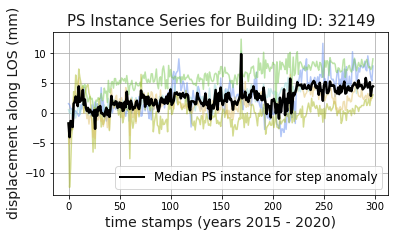

In [154]:
from matplotlib import lines

legend_element = [lines.Line2D([0], [0], color='black',lw=2, linestyle="solid")]
color_elements={'trend':'royalblue','noise':'blueviolet','step':'c'}                   
label_names={"trend":"trend","noise":"noise","step":"step"}
colors_list = ['#6890F0','#98D8D8','#78C850','#A8B820','#E0C068', '#F08030', '#C03028', '#F85888','#F8D030'] 
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)
                   
selected_array=ts_test[array_ids]
for idx,arr in enumerate(selected_array):
    ax.plot(arr, color=colors_list[idx], alpha=.5)
ax.plot(np.median(selected_array,0).ravel(), color="black",linewidth=2.5)
ax.set_title("PS Instance Series for Building ID: {}".format(ID),size = 15,alpha=0.9)
ax.legend(legend_element, ["Median PS instance for {} anomaly".format(label_names[ANOMALY])],prop={'size': 12})
ax.set_xlabel('time stamps (years 2015 - 2020)',size = 14,alpha=0.9)
ax.set_ylabel('displacement along LOS (mm)',size = 14,alpha=0.9)
ax.grid()
fig.savefig('ps_instances_{}_{}.png'.format(ID,ANOMALY),dpi=300,bbox_inches='tight')

In [155]:
df_ano_build[df_ano_build.footprint_id==ID]

,footprint_id,anomaly_type,trend_anomaly_likelihood,noise_anomaly_likelihood,step_anomaly_likelihood,number_of_anomaly_points,number_of_total_point,observation_confidence,latitude,longitude
10,32149,step,0.14,0.14,0.71,7,25,0.28,41.883281,12.503454


**ATTENTION: NON STABLE TRIALS: DATA CLASSIFICATION**

In [ ]:
#REAL Random Forest
from pyts.datasets import load_gunpoint
from pyts.classification import TimeSeriesForest
from sklearn.model_selection import train_test_split
from tslearn.preprocessing import TimeSeriesScalerMinMax,TimeSeriesScalerMeanVariance


X_train, X_test, y_train, y_test = train_test_split(x_test_synthetic_norm, y_true, stratify=y_true, test_size=0.25, random_state=42)
#scaler=TimeSeriesScalerMeanVariance()
#scaler.fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

#X_train, X_test, y_train, y_test = load_gunpoint(return_X_y=True)
RF_ts = TimeSeriesForest(random_state=42,n_windows=5)
RF_ts.fit(X_train[:,:,0], y_train)
RF_ts.score(X_test[:,:,0], y_test)


In [ ]:
#REAL SVC
import numpy
import matplotlib.pyplot as plt

from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax,TimeSeriesScalerMeanVariance
from tslearn.svm import TimeSeriesSVC

numpy.random.seed(0)
#X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
X_train, X_test, y_train, y_test = train_test_split(x_test_synthetic_norm, y_true, test_size=0.25, random_state=42)


#scaler=TimeSeriesScalerMinMax()
#scaler.fit(X_train)
#X_train = paa.transform(X_train[:,:,0])
#X_test = paa.transform(X_test[:,:,0])

SVM = TimeSeriesSVC(kernel="poly",n_jobs=-1, degree=2)
SVM.fit(X_train, y_train)
print("Correct classification rate:", SVM.score(X_test, y_test))

n_classes = len(set(y_train))

plt.figure()
support_vectors = SVM.support_vectors_
for i, cl in enumerate(set(y_train)):
    plt.subplot(n_classes, 1, i + 1)
    plt.title("Support vectors for class %d" % cl)
    for ts in support_vectors[i]:
        plt.plot(ts.ravel())

plt.tight_layout()
plt.show()

In [ ]:
n_classes

In [ ]:
from pyts.approximation import PiecewiseAggregateApproximation

# Parameters
n_samples, n_timestamps = x_train[:,0:300,0].shape

# Toy dataset
#rng = np.random.RandomState(41)
#X = rng.randn(n_samples, n_timestamps)
X_train, X_test, y_train, y_test = train_test_split(x_train[:,0:300,0], y_true, test_size=0.25, random_state=42)
X=X_train

# PAA transformation
window_size = 6
paa = PiecewiseAggregateApproximation(window_size=window_size)
X_paa = paa.transform(X)

# Show the results for the first time series
plt.figure(figsize=(6, 4))
plt.plot(X[0], 'o--', ms=4, label='Original')
plt.plot(np.arange(window_size // 2,
                   n_timestamps + window_size // 2,
                   window_size), X_paa[0], 'o--', ms=4, label='PAA')
plt.vlines(np.arange(0, n_timestamps, window_size) - 0.5,
           X[0].min(), X[0].max(), color='g', linestyles='--', linewidth=0.5)
plt.legend(loc='best', fontsize=10)
plt.xlabel('Time', fontsize=12)
plt.title('Piecewise Aggregate Approximation', fontsize=16)
plt.show()

In [ ]:
label_names=["trend","noise", "step" ]
cluster_center_colors=np.array([[0,1,0],[1,0,0],[0,0,1]])

distance_test_organic=RF_ts.predict_proba(x_test_organic_norm[:,:,0])
distance_test_synthetic=RF_ts.predict_proba(x_test_synthetic_norm[:,:,0])
preds=np.argmax(distance_test_synthetic,-1)
one_hot_preds=np.eye(3)[preds] 
test_synthetic_colors=distance_test_synthetic*one_hot_preds


In [ ]:
plt.hist(pred_1, bins='auto') 

In [ ]:
#plot_3d(distance_test_organic)

In [ ]:
rescale_size = 64
n_scales = 256
w1="shan"

cluster_centers_cwt = create_cwt_images(cluster_centers, n_scales, rescale_size,w1)
x_test_synthetic_norm_cwt = create_cwt_images(x_test_synthetic_norm_sub, n_scales, rescale_size,w1)
x_test_organic_norm_cwt = create_cwt_images(x_test_organic_norm_sub, n_scales, rescale_size,w1)

cluster_centers_cwt_flattened=cluster_centers_cwt.reshape(cluster_centers_cwt.shape[0],cluster_centers_cwt.shape[1]*cluster_centers_cwt.shape[1])
x_test_synthetic_norm_cwt_flattened=x_test_synthetic_norm_cwt.reshape(x_test_synthetic_norm_cwt.shape[0],x_test_synthetic_norm_cwt.shape[1]*x_test_synthetic_norm_cwt.shape[1])
x_test_organic_norm_cwt_flattened=x_test_organic_norm_cwt.reshape(x_test_organic_norm_cwt.shape[0],x_test_organic_norm_cwt.shape[1]*x_test_organic_norm_cwt.shape[1])


**ATTENTION: NON STABLE TRIALS: MANIFOLD LEARNING**

In [ ]:
from sklearn import manifold

t_sne = manifold.TSNE(
    n_components=2,
    perplexity=15,
    init="pca",
    n_iter=550,
    random_state=42, n_jobs=-1, verbose=1)

d_scaling = manifold.MDS(
    n_components=2,
    max_iter=50,
    n_init=6,
    random_state=42, n_jobs=-1, verbose=1
)

manifolder=t_sne.fit_transform(np.concatenate([cluster_centers_cwt_flattened,x_test_synthetic_norm_cwt_flattened]))

cluster_center_tsne = manifolder[:3,:]
synthetic_test_tsne = manifolder[3:,:]



In [ ]:
plot_2d(synthetic_test_tsne, test_synthetic_colors, cluster_center_tsne, cluster_center_colors,label_names, "T-distributed Stochastic Neighbor Embedding")

In [ ]:
t_sne = manifold.TSNE(
    n_components=2,
    perplexity=15,
    init="pca",
    n_iter=1000,
    random_state=42, n_jobs=-1, verbose=1)
manifolder=t_sne.fit_transform(np.concatenate([cluster_centers_cwt_flattened,x_test_synthetic_norm_cwt_flattened]))

cluster_center_tsne = manifolder[:3,:]
synthetic_test_tsne = manifolder[3:,:]
plot_2d(synthetic_test_tsne, test_synthetic_colors, cluster_center_tsne, cluster_center_colors,label_names, "T-distributed Stochastic Neighbor Embedding")

In [ ]:
t_sne = manifold.TSNE(
    n_components=2,
    perplexity=10,
    init="pca",
    n_iter=1000,
    random_state=42, n_jobs=-1, verbose=1)
manifolder=t_sne.fit_transform(np.concatenate([cluster_centers_cwt_flattened,x_test_synthetic_norm_cwt_flattened]))

cluster_center_tsne = manifolder[:3,:]
synthetic_test_tsne = manifolder[3:,:]
plot_2d(synthetic_test_tsne, test_synthetic_colors, cluster_center_tsne, cluster_center_colors,label_names, "T-distributed Stochastic Neighbor Embedding")

In [ ]:
t_sne = manifold.TSNE(
    n_components=2,
    perplexity=40,
    init="pca",
    n_iter=1000,
    random_state=42, n_jobs=-1, verbose=1)
manifolder=t_sne.fit_transform(np.concatenate([cluster_centers_cwt_flattened,x_test_synthetic_norm_cwt_flattened]))

cluster_center_tsne = manifolder[:3,:]
synthetic_test_tsne = manifolder[3:,:]
plot_2d(synthetic_test_tsne, test_synthetic_colors, cluster_center_tsne, cluster_center_colors,label_names, "T-distributed Stochastic Neighbor Embedding")

In [ ]:
t_sne = manifold.TSNE(
    n_components=3,
    perplexity=40,
    init="pca",
    n_iter=1000,
    random_state=42, n_jobs=-1, verbose=1)
manifolder=t_sne.fit_transform(np.concatenate([cluster_centers_cwt_flattened,x_test_synthetic_norm_cwt_flattened]))

cluster_center_tsne = manifolder[:3,:]
synthetic_test_tsne = manifolder[3:,:]
#plot_3(synthetic_test_tsne, test_synthetic_colors, cluster_center_tsne, cluster_center_colors,label_names, "T-distributed Stochastic Neighbor Embedding")

**ATTENTION: NON STABLE TRIALS: CNN BASED CLASSIFICATION**

In [ ]:

label_names=["trend","noise", "step" ]

# list of list of sample indicies per activity
train_labels_indicies = split_indices_per_label(y_train)

#signal indicies: 0 = body acc x, 1 = body acc y, 2 = body acc z, 3 = body gyro x, 4 = body gyro y, 5 = body gyro z, 6 = total acc x, 7 = total acc y, 8 = total acc z
signal = 4 # signal index
sample = 100 # sample index of each label indicies list
scales = np.arange(1, 256) # range of scales
wavelet = "shan"#'morl' # mother wavelet

plot_cwt_coeffs_per_label(X_train, train_labels_indicies, label_names, signal, sample, scales, wavelet)


In [ ]:



# list of list of sample indicies per activity
train_labels_indicies = split_indices_per_label(y_true)

#signal indicies: 0 = body acc x, 1 = body acc y, 2 = body acc z, 3 = body gyro x, 4 = body gyro y, 5 = body gyro z, 6 = total acc x, 7 = total acc y, 8 = total acc z
signal = 0 # signal index
sample = 100 # sample index of each label indicies list
scales = np.arange(1, 256) # range of scales
wavelet = "cmor"#'morl' # mother wavelet

plot_cwt_coeffs_per_label(x_train_raw, train_labels_indicies, label_names, signal, sample, scales, wavelet)


In [ ]:
pywt.wavelist(kind='continuous')

In [ ]:
X_train_cwt, X_test_cwt, y_train, y_test = train_test_split(x_test_synthetic_norm_cwt, y_true, test_size=0.25, random_state=42)
X_train_cwt, X_valid_cwt, y_train, y_valid = train_test_split(X_train_cwt, y_train, test_size=0.25, random_state=42)


In [ ]:
# amount of pixels in X and Y 
rescale_size = 64
# determine the max scale size
n_scales = 256

#X_train, X_test, y_train, y_test = train_test_split(x_train_raw, y_true, test_size=0.25, random_state=42)

w1="shan"
w2="cmor"
X_train_cwt = create_cwt_images(X_train, n_scales, rescale_size,w1)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: {X_train_cwt.shape}")
X_test_cwt = create_cwt_images(X_test, n_scales, rescale_size,w1)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_test_cwt: {X_test_cwt.shape}")

In [ ]:


# shape of the input images
input_shape = (X_train_cwt.shape[1], X_train_cwt.shape[2], X_train_cwt.shape[3])

# create cnn model
cnn_model = build_cnn_model("relu", input_shape)
# train cnn model
trained_cnn_model, cnn_history = compile_and_fit_model(cnn_model, X_train_cwt, y_train, X_valid_cwt, y_valid, 256, 20)


In [ ]:
# make predictions for test data
y_pred_cnn = np.argmax(trained_cnn_model.predict(X_test_cwt),1)
print(y_pred.shape)
print(y_test.shape)
# determine the total accuracy 
accuracy = metrics.accuracy_score(y_test, y_pred_cnn)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

create_confusion_matrix(y_pred_cnn, y_test,label_names)
print(classification_report(y_test, y_pred_cnn))


In [ ]:
trained_cnn_model.predict(X_test_cwt).shape

In [ ]:
# -*- coding: utf-8 -*-

"""
Bhavanisagar reservoir (TamilNadu, India) flood - 2019
The time series consists of 7 images: 23 June 2019, 5 July 2019, 17 July 2019, 29 July 2019, 10 August 2019, 22 August 2019, 03 September 2019

The flood had happened by 8th/9th August: https://www.newindianexpress.com/states/tamil-nadu/2019/aug/10/rise-in-water-level-prompts-flood-alert-2016799.html

This code analyzes all 7 images: T0, T1, T2, T3, T4, T5, T6


Train and Test zone are spatially independent.
"""

import torch
import torch.nn as nn
from lstmEncoder import LSTM
from tqdm import tqdm
import optuna
from optuna.samplers import TPESampler
import argparse
import warnings
import pandas as pd
import joblib
import gc
import numpy as np
from utils_project import  AvgMeter, get_lr
from data_loader import Dataloader
from tslearn.metrics import soft_dtw
import os
import copy
from custom_loss import SoftDTW


warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)



import torch
import torch.nn.functional as F

class SoftDTWLoss(torch.nn.Module):
    ''' This the loss function for Sparse Autoencoder.
    '''
    def __init__(self):
        super(SoftDTWLoss, self).__init__()
        self.loss_func=SoftDTW(use_cuda=torch.cuda.is_available(), gamma=0.1)

    def forward(self, output, target):
        loss=self.loss_func(output, target)
        return loss.mean()



def train_validate(model, ts_train,ts_val,learning_rate, penalty_rate, output_file_template, device):
    '''
        THIS FUNCTION MANAGES THE EXECUTION OF TRAINING AND VALIDATION EPOCHS
        :param model: CLIP model to be fine-tuned
        :param train_loader: data loader for training files
        :param valid_loader: data loader for validation files
        :param learning_rate: learning rate for optimization
        :param downstream_task: one of few-shot learning tasks 'DEFAULT', 'ARC_HEAD','MLP_HEAD','ARC_MLP_HEAD'
        :param output_template: file name template to save the fine-tuned models and inference statistics
        :param device: GPU or CPU device
        :return:
    '''

    best_model=None
    #optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), betas=(0.9,0.98),eps=1e-6, lr=learning_rate,weight_decay=penalty_rate)  # weight_decay=0.0001
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)  # model.parameters is the parameters that optimizerd have to change

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    #loss_criterion = nn.L1Loss().to(device)
    loss_criterion=SoftDTWLoss().to(device)

    step = "epoch"
    best_loss = float('inf')
    for epoch in range(args.total_epoch):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_epoch(model, ts_train, optimizer, lr_scheduler, loss_criterion, step, device)
        model.eval()
        with torch.no_grad():
            valid_loss, image_batch = valid_epoch(model, ts_val, loss_criterion, device)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            best_model = copy.deepcopy(model)
            torch.jit.save(torch.jit.trace(model, (image_batch)),'{}_model_best.pth.tar'.format(output_file_template))
            # torch.save(model.state_dict(), "model_best.pth.tar")
            print("INFO: Best Model saved into " + '{}_model_best.pth.tar'.format(output_file_template))

        lr_scheduler.step(valid_loss.avg)
    return best_model


def train_epoch(model, train_loader, optimizer, lr_scheduler, loss_criterion, step, device):
    '''
         THIS FUNCTION RUNS THE SINGLE TRAINING EPOCHS
         :param model: CLIP model to be fine-tuned
         :param train_loader: data loader for training files
         :param optimizer: model optimizer object
         :param lr_scheduler: scheduler object to update the learning rate for optimization
         :param loss_criterion: loss objective function to be utilized for backprop
         :param step: epoch step number
         :param device: GPU or CPU device
         :return: returns average training loss
    '''

    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for data_batch, permuted_data_batch, foot_batch in tqdm_object:
        output = model(permuted_data_batch.to(device))
        loss = loss_criterion(output,data_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = data_batch.size(1)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter




def valid_epoch(model, valid_loader, loss_criterion, device):
    '''
         THIS FUNCTION RUNS THE SINGLE TRAINING EPOCHS
         :param model: CLIP model to be fine-tuned
         :param valid_loader: data loader for validation files
         :param loss_criterion: loss objective function to be utilized for backprop
         :param step: epoch step number
         :param device: GPU or CPU device
         :return: returns the tuple of ( average validation loss, an image batch example, a text batch example).
                  image and text batches are used as template to save the model if it reaches the optimum
    '''

    loss_meter = AvgMeter()



    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for data_batch, permuted_data_batch, foot_batch in tqdm_object:
        output = model(permuted_data_batch.to(device))
        loss = loss_criterion(output,data_batch.to(device))

        count = data_batch.size(1)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter, data_batch.to(device)



def main(args):

    if not os.path.exists(args.log_dir):
        os.makedirs(args.log_dir,exist_ok=True)


    MANUAL_SEED=42
    LABEL_NAMES = ["trend", "noise", "step"]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    torch.manual_seed(MANUAL_SEED)  # set seed (manually) for generate random numbers with CPU
    torch.cuda.manual_seed(MANUAL_SEED)  # set seed (manually) for generate random numbers with GPU --> "CUDA = GPU"
    np.random.seed(MANUAL_SEED)



    data_loader = Dataloader(args.train_dir,
                             args.eval_dir,
                             split=0.25,
                             batch_size=args.batch_size,
                             num_workers=1,
                             seed=MANUAL_SEED)

    model = LSTM(inputFeatureDim=data_loader.get_data_dimensions()[-1],
                 latentFeatureDim=data_loader.get_data_dimensions()[-1],
                 numLayersEncoder=2,
                 numLayersDecoder=1)

    model = model.to(device)

    #trainDataPath = 'data/database_train.csv'
    #testDataPath = 'data/database_test.csv'

    #nPoints = 299 # Number of data points in the time series. Convenient to set a lower value for prototyping because of the memory cost.
    #trainingDataSize = 354964 # number of samples for training LSTM
    #validationDataSize = 88741 # number of validation samples
    #testSplitSize = 99028 # If taking a subset of the test set
    #numOfTrainingIterations=400   ##Number of iterations for LSTM training
    #batchSizeForTraining=256 ##batch size for training LSTM
    #validationFrac = 0.2

    # Reading training data..


    def objective(trial):
        '''
            THIS FUNCTION DEFINES THE OBJECTIVE FUNCTION FOR BAYESIAN HYPERPARAMETER TUNING
            :param trial: trial object of bayesian optimization
            :return: returns weighted F1 score to be maximized
        '''

        gc.collect()

        print(f"INFO: Trial number: {trial.number}\n")

        learning_rate = trial.suggest_categorical('learning_rate', args.learning_rate)
        penalty_rate = trial.suggest_categorical('penalty_rate', args.penalty_rate)

        output_file_template = '{}_{}_{}_{}'.format(args.log_dir,learning_rate,penalty_rate, trial.number)

        model = LSTM(inputFeatureDim=data_loader.get_data_dimensions()[-1],
                     latentFeatureDim=data_loader.get_data_dimensions()[-1],
                     numLayersEncoder=2,
                     numLayersDecoder=1)

        model = model.to(device)

        best_model = train_validate(model, data_loader.get_data_loader('train'), data_loader.get_data_loader('valid'),learning_rate, penalty_rate, output_file_template, device)

        return 0

    study = optuna.create_study(sampler=TPESampler(), direction='minimize',
                                pruner=optuna.pruners.MedianPruner(n_startup_trials=5,
                                                                   n_warmup_steps=24,
                                                                   interval_steps=6))
    log_file = args.log_dir + 'optimization_logs.pkl'
    if os.path.isfile(log_file):
        study = joblib.load(log_file)

    study.optimize(objective, n_trials=args.n_trials, gc_after_trial=True)
    joblib.dump(study, log_file)


In [ ]:
import sys; sys.argv=['']; del sys
parser = argparse.ArgumentParser()
parser.add_argument('--train-dir', type=str, default='../data/database_train.csv')
parser.add_argument('--eval-dir', type=str, default='../data/database_test.csv')
parser.add_argument('--batch-size', default=1024, type=int, metavar='BS',help='number of batch size (default: 32)')
parser.add_argument('--log-dir', type=str, default='../results/optuna/')
parser.add_argument('--total-epoch', type=int, default=60)
parser.add_argument('--num-workers', type=int, default=8)
parser.add_argument('--n-trials', type=int, default=2)
parser.add_argument('--learning-rate', type=float, nargs='+', default=[1e-2, 1e-3, 5e-4, 1e-4, 5e-5])
parser.add_argument('--penalty-rate', type=float, nargs='+', default=[1e-2]) #5e-3, 1e-3, 5e-4
args=parser.parse_args()
main(args)


In [ ]:


df_data_synthetic_test = pd.read_csv('../data/valdataset_3_3_3.csv')


In [ ]:
def anomaly_statistics(pred):
    Q1 = np.percentile(pred,25)
    med = np.median(pred)
    Q3 = np.percentile(pred,75)
    IQR = Q3 - Q1
    LowerWhisker = np.max([pred.min() , Q1-1.5*IQR])
    UpperWhisker = np.min([pred.max() , Q3 + 1.5 * IQR]) 
    return (LowerWhisker,UpperWhisker)

In [ ]:
df=df_data_synthetic_test.groupby(['footprint_id'])

In [ ]:
df_results.info()

In [ ]:
threshold=0.5
counter2=0
counter1=0
for group_name, df_group in df_results.groupby(['footprint_id']):
    counter1=counter1+1
    if (sum(df_group.anomaly>0)/len(df_group) >= 0.5) and (len(df_group)>1):
        counter2=counter2+1
print("Anomalous Ground Truth Building size: {}".format(counter2))
print("Total Building size: {}".format(counter1))

In [ ]:
d,u=anomaly_statistics(df_results.loss.values)

In [ ]:
anom_df=df_results[df_results.loss>=u]

In [ ]:
sum(anom_df.anomaly==3)

In [ ]:
df_results_organic = pd.read_csv('results/_5e-05_0.01_2_prediction_results_organic.csv')
df_results_synthetic = pd.read_csv('results/_5e-05_0.01_2_prediction_results_synthetic.csv')

In [ ]:
LABEL_NAMES = ["trend", "noise", "step"]
d,u=anomaly_statistics(df_results_organic.loss.values)
df_synthetic_anom=df_results_synthetic[df_results.loss>=u]
df_synthetic_norm=df_results_synthetic[df_results.loss<u]
TP_trend=sum(df_synthetic_anom.anomaly==1)
TP_noise=sum(df_synthetic_anom.anomaly==2)
TP_step=sum(df_synthetic_anom.anomaly==3)

FN_trend=sum(df_synthetic_anom.anomaly==1)
FN_noise=sum(df_synthetic_anom.anomaly==2)
FN_step=sum(df_synthetic_anom.anomaly==3)

trend_acc=TP_trend/()